## Customer Retention & Revenue Analysis

This notebook explores customer behavior and revenue patterns using SQL-based analysis
on an online retail dataset. The goal is to identify key business insights related to
customer value, retention, and purchasing behavior.

### Business Questions

1. What are the key revenue and customer KPIs?
2. How concentrated is revenue among customers?
3. What is the difference between one-time and repeat customers?
4. How does customer behavior evolve over time?
5. Which customer segments drive the most value?

### Data & Assumptions

- Data represents historical online retail transactions [Retail Dataset](https://www.kaggle.com/datasets/ulrikthygepedersen/online-retail-dataset)
- Revenue is calculated as Quantity × UnitPrice
- Analysis focuses on completed transactions only
- Customer-level analysis excludes records without CustomerID

### Key Insights


| Insight Area | Key Finding | Business Implication |
|-------------|------------|----------------------|
| Customer retention | Over **90% of total revenue is generated by repeat customers** | Retention, churn prevention, and lifecycle monitoring are the primary levers of revenue growth |
| Early lifecycle behavior | **Only ~15–30% of customers return after their first purchase** | Improving early engagement and onboarding offers the largest optimization opportunity |
| Acquisition quality | Later cohorts are smaller but show **comparable or slightly stronger retention** | Customer quality and acquisition efficiency remain stable despite lower volume |
| Customer segmentation (RFM) | High-value segments (Champions, Loyal Customers) are small but revenue-dominant | Segment-specific strategies are required to protect and grow high-value customers |
| Growth experimentation | Potential Loyalists and Can’t Lose segments present high-impact opportunities | Targeted experimentation can significantly increase lifetime value with limited investment |

---

### 1. Import

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
plt.style.use("seaborn-v0_8-muted")

##### 1.1. Connect to the SQLite database

In [3]:
conn = sqlite3.connect("../data/online_retail.db")

In [4]:
pd.read_sql("""
SELECT COUNT(*) AS total_rows
FROM orders;
""", conn)

,total_rows
0,392692


---

### 2. Core business KPIs

In [5]:
pd.read_sql("""
SELECT
  ROUND(SUM(Revenue), 2)                         AS total_revenue,
  COUNT(DISTINCT InvoiceNo)                      AS total_orders,
  COUNT(DISTINCT CustomerID)                     AS total_customers,
  ROUND(SUM(Revenue) / COUNT(DISTINCT InvoiceNo), 2) AS avg_order_value,
  ROUND(
    COUNT(DISTINCT InvoiceNo) * 1.0 
    / COUNT(DISTINCT CustomerID), 2
  )                                              AS orders_per_customer
FROM orders;
""", conn)

,total_revenue,total_orders,total_customers,avg_order_value,orders_per_customer
0,8887208.89,18532,4338,479.56,4.27


---

### 3. Revenue Concentration

##### 3.1. Top 10 Customers

In [6]:
pd.read_sql("""
SELECT
  CustomerID,
  ROUND(SUM(Revenue), 2) AS customer_revenue
FROM orders
GROUP BY CustomerID
ORDER BY customer_revenue DESC
LIMIT 10;
""", conn)

,CustomerID,customer_revenue
0,14646.0,280206.02
1,18102.0,259657.30
2,17450.0,194390.79
3,16446.0,168472.50
4,14911.0,143711.17
5,12415.0,124914.53
6,14156.0,117210.08
7,17511.0,91062.38
8,16029.0,80850.84
9,12346.0,77183.60


##### 3.2 Share of Revenue from Top Customers

In [7]:
pd.read_sql("""
WITH customer_revenue AS (
  SELECT
    CustomerID,
    SUM(Revenue) AS revenue
  FROM orders
  GROUP BY CustomerID
)
SELECT
  ROUND(SUM(revenue), 2) AS top_10_revenue,
  ROUND(
    SUM(revenue) * 100.0 / (SELECT SUM(Revenue) FROM orders),
    2
  ) AS top_10_revenue_pct
FROM (
  SELECT revenue
  FROM customer_revenue
  ORDER BY revenue DESC
  LIMIT 10
);
""", conn)

,top_10_revenue,top_10_revenue_pct
0,1537659.21,17.3


➤ Insights. **Revenue Concentration** 

A small group of customers (Top 10) accounts for a large share of total revenue **17.3%**,
indicating customer value is highly concentrated.

---

### 4. Repeat vs One-Time Customers

4.1. Classify customers by purchase frequency

In [8]:
pd.read_sql("""
WITH customer_orders AS (
  SELECT
    CustomerID,
    COUNT(DISTINCT InvoiceNo) AS orders_count
  FROM orders
  GROUP BY CustomerID
),
customer_revenue AS (
  SELECT
    CustomerID,
    SUM(Revenue) AS revenue
  FROM orders
  GROUP BY CustomerID
),
customer_summary AS (
  SELECT
    co.CustomerID,
    CASE
      WHEN co.orders_count = 1 THEN 'One-time'
      ELSE 'Repeat'
    END AS customer_type,
    cr.revenue
  FROM customer_orders co
  JOIN customer_revenue cr
    ON co.CustomerID = cr.CustomerID
)
SELECT
  customer_type,
  COUNT(*) AS customers,
  ROUND(SUM(revenue), 2) AS total_revenue,
  ROUND(
    SUM(revenue) * 100.0 / (SELECT SUM(Revenue) FROM orders),
    2
  ) AS revenue_pct,
  ROUND(AVG(revenue), 2) AS avg_revenue_per_customer
FROM customer_summary
GROUP BY customer_type;
""", conn)


,customer_type,customers,total_revenue,revenue_pct,avg_revenue_per_customer
0,One-time,1493,613989.56,6.91,411.25
1,Repeat,2845,8273219.33,93.09,2907.99


➤ Insight. **Customer Purchase Frequency**    

Repeat customers account for **93.09% of total revenue**, while one-time customers contribute
only **6.91%**. In addition, repeat customers generate a **significantly higher average revenue
per customer**, reinforcing retention as a key driver of business value and long-term growth.

---

### 5. Cohort Analysis

In [9]:
cohort_df = pd.read_sql("""
WITH first_purchase AS (
  SELECT
    CustomerID,
    DATE(MIN(InvoiceDate), "start of month") AS cohort_month
  FROM orders
  GROUP BY CustomerID
),
orders_with_cohort AS (
  SELECT
    o.CustomerID,
    DATE(o.InvoiceDate, "start of month") AS order_month,
    fp.cohort_month
  FROM orders o
  JOIN first_purchase fp
    ON o.CustomerID = fp.CustomerID
),
cohort_activity AS (
  SELECT
    cohort_month,
    (
      (CAST(strftime("%Y", order_month) AS INTEGER) - CAST(strftime("%Y", cohort_month) AS INTEGER)) * 12
      + (CAST(strftime("%m", order_month) AS INTEGER) - CAST(strftime("%m", cohort_month) AS INTEGER))
    ) AS months_since_first_purchase,
    COUNT(DISTINCT CustomerID) AS active_customers
  FROM orders_with_cohort
  GROUP BY cohort_month, months_since_first_purchase
),
cohort_size AS (
  SELECT
    cohort_month,
    COUNT(DISTINCT CustomerID) AS cohort_customers
  FROM first_purchase
  GROUP BY cohort_month
)
SELECT
  ca.cohort_month,
  ca.months_since_first_purchase,
  cs.cohort_customers AS cohort_size,
  ca.active_customers AS retention_count,
  ROUND(
    ca.active_customers * 100.0 / cs.cohort_customers,
    2
  ) AS retention_pct
FROM cohort_activity ca
JOIN cohort_size cs
  ON ca.cohort_month = cs.cohort_month
ORDER BY ca.cohort_month, ca.months_since_first_purchase;
""", conn)

#### 5.1. Retention Counts

In [10]:
cohort_pivot_count = cohort_df.pivot(
    index="cohort_month",
    columns="months_since_first_purchase",
    values="retention_count"
)

In [11]:
cohort_pivot_count

months_since_first_purchase,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 5.2. Retention %

In [12]:
cohort_pivot_pct = cohort_df.pivot(
    index="cohort_month",
    columns="months_since_first_purchase",
    values="retention_pct"
)

In [13]:
cohort_pivot_pct

months_since_first_purchase,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,,
2010-12-01,100.0,36.61,32.32,38.42,36.27,39.77,36.27,34.92,35.37,39.55,37.40,50.28,26.55
2011-01-01,100.0,22.06,26.62,23.02,32.13,28.78,24.70,24.22,29.98,32.61,36.45,11.75,NaN
2011-02-01,100.0,18.68,18.68,28.42,27.11,24.74,25.26,27.89,24.74,30.53,6.84,NaN,NaN
2011-03-01,100.0,15.04,25.22,19.91,22.35,16.81,26.77,23.01,27.88,8.63,NaN,NaN,NaN
2011-04-01,100.0,21.33,20.33,21.00,19.67,22.67,21.67,26.00,7.33,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.01,17.25,17.25,20.77,23.24,26.41,9.51,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.36,15.70,26.45,23.14,33.47,9.50,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.09,20.74,22.34,27.13,11.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.71,24.85,24.26,12.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 5.3. Retention Plot

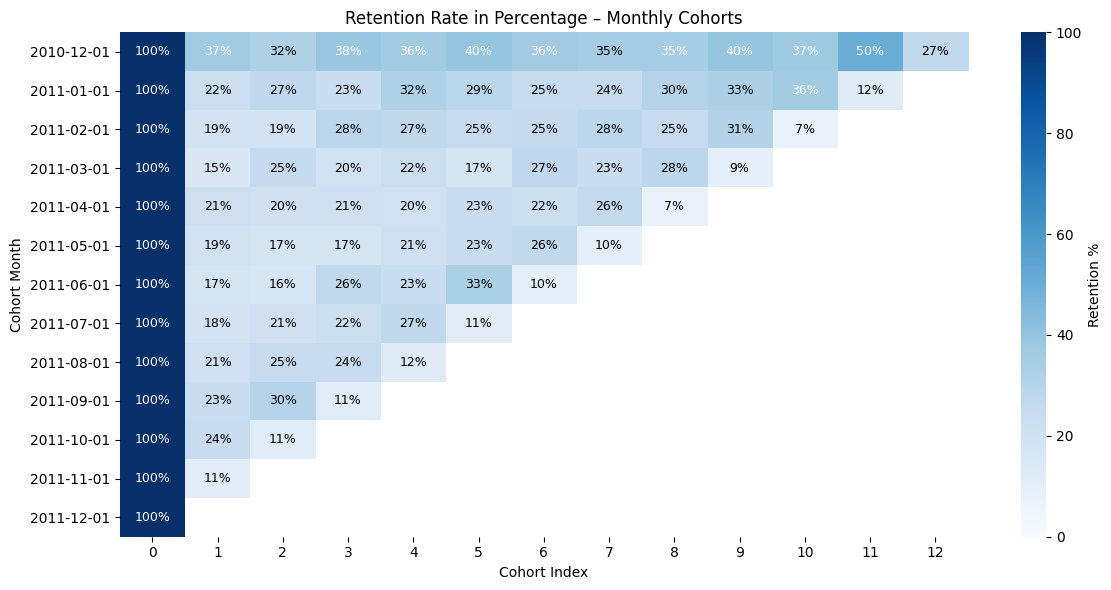

In [14]:

plt.figure(figsize=(12, 6))

ax = plt.imshow(
    cohort_pivot_pct,
    aspect="auto",
    cmap="Blues",
    vmin=0,
    vmax=100
)

cbar = plt.colorbar(ax)
cbar.set_label("Retention %")
cbar.outline.set_visible(False)

plt.xticks(
    range(len(cohort_pivot_pct.columns)),
    cohort_pivot_pct.columns
)
plt.yticks(
    range(len(cohort_pivot_pct.index)),
    cohort_pivot_pct.index
)

plt.xlabel("Cohort Index")
plt.ylabel("Cohort Month")
plt.title("Retention Rate in Percentage – Monthly Cohorts")

for spine in plt.gca().spines.values():
    spine.set_visible(False)

for i in range(cohort_pivot_pct.shape[0]):
    for j in range(cohort_pivot_pct.shape[1]):
        value = cohort_pivot_pct.iloc[i, j]
        if not pd.isna(value):
            plt.text(
                j,
                i,
                f"{value:.0f}%",
                ha="center",
                va="center",
                fontsize=9,
                color="white" if value > 35 else "black"
            )

plt.tight_layout()
plt.show()


#### ➤ Insights. **Cohort Retention**

| Observation | Evidence from Cohorts | Business Interpretation |
|------------|----------------------|--------------------------|
| Strong early churn | **Only ~15–30%** of customers return in Month 1| First purchase does not guarantee retention |
| Retention stabilizes over time | retention gradually stabilizes, with ~**10–20% of customers remaining active beyond Month 4–6** | A core group of long-term customers. |
| Similar retention across cohorts | Later cohorts show comparable early retention. | Customer acquisition quality is stable |
| Long-term customers are critical | Small retained base aligns with >90% revenue from repeat customers | Retention drives most business value |

#### Early vs Late Cohort Comparison

While later cohorts demonstrate **comparable or slightly stronger retention rates** in the
early lifecycle stages, the **overall cohort sizes are smaller** compared to earlier periods.
This suggests that although customer acquisition volume has declined, the **quality of
acquired customers has remained stable or improved**.

From a business perspective, this indicates a shift toward **fewer but more engaged customers**,
emphasizing the importance of optimizing acquisition efficiency and maximizing lifetime value
rather than focusing solely on growth in customer count.

---

### 6. RFM Analysis

#### 6.1. Customer Segmentation 

RFM analysis segments customers based on:
- **Recency**: days since last purchase
- **Frequency**: number of purchases
- **Monetary**: total revenue generated

This approach helps identify high-value customers, retention opportunities,
and segments at risk of churn.


#### 6.2. RFM Base Table (SQL to Python)

In [15]:
rfm_df = pd.read_sql("""
WITH customer_metrics AS (
  SELECT
    CustomerID,
    MAX(DATE(InvoiceDate)) AS last_purchase_date,
    COUNT(DISTINCT InvoiceNo) AS frequency,
    SUM(Revenue) AS monetary
  FROM orders
  GROUP BY CustomerID
),
reference_date AS (
  SELECT DATE(MAX(InvoiceDate), "+1 day") AS ref_date
  FROM orders
)
SELECT
  cm.CustomerID,
  CAST(JULIANDAY(rd.ref_date) - JULIANDAY(cm.last_purchase_date) AS INTEGER) AS recency,
  cm.frequency,
  ROUND(cm.monetary, 2) AS monetary
FROM customer_metrics cm
CROSS JOIN reference_date rd;
""", conn)


In [16]:
rfm_df.head()

,CustomerID,recency,frequency,monetary
0,12346.0,326,1,77183.60
1,12347.0,3,7,4310.00
2,12348.0,76,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,311,1,334.40


#### 6.3. RFM Scoring 

In [17]:
rfm_scored = rfm_df.copy()

In [18]:
rfm_scored["R_score"] = (
    rfm_scored["recency"]
    .rank(method="first", ascending=True)
    .pipe(pd.qcut, 5, labels=[5, 4, 3, 2, 1])
    .astype(int)
)

rfm_scored["F_score"] = (
    rfm_scored["frequency"]
    .rank(method="first", ascending=True)
    .pipe(pd.qcut, 5, labels=[1, 2, 3, 4, 5])
    .astype(int)
)

rfm_scored["M_score"] = (
    rfm_scored["monetary"]
    .rank(method="first", ascending=True)
    .pipe(pd.qcut, 5, labels=[1, 2, 3, 4, 5])
    .astype(int)
)


#### 6.4. Segment Assignment

In [19]:
rfm_scored["RF_score"] = (
    rfm_scored["R_score"].astype(str) +
    rfm_scored["F_score"].astype(str)
)

Categorize the customers based on their RFM values into groups:

- **Champions:** Bought recently, buy often and spend the most.
- **Loyal Customers (High Frequency, Low Recency, High Monetary):** These customers buy often and spend a lot. They are recent buyers, indicating ongoing engagement.
- **Potential Loyalist:** Recent customers but spent a good amount and bought more than once.
- **Recent Customers:** Bought most recently but not often.
- **Promising:** Recent buyers but haven't spent much.
- **Customers Needing Attention:** Above average recency, frequency and monetary values. May not have bought very recently though.
- **About to Slip:** Below average recency, frequency and monetary values. Will lose them if not reactivated.
- **New Customers (Low Frequency, Low Recency, Low/Medium Monetary):** These are customers who have started buying recently but have not yet bought frequently or spent a lot.
- **At-Risk Customers (Low Frequency, High Recency, Medium/High Monetary):** These are customers who used to buy frequently and spend a significant amount, but it's been long time they purchased.
- **Lost Customers (Low Frequency, High Recency, Low Monetary):** These customers have not purchased in a long time, they seldom bought and when they do, they spend little.
- **Can't Lose Them:** Made biggest purchases and often. But haven't returned for a long time.
- **Hibernating:** Last purchases was long back, with low spenders and low number of orders.

In [20]:
segment_map = {
    r"[1-2][1-2]": "Hibernating",
    r"[1-2][3-4]": "At-Risk",
    r"[1-2]5": "Can't Lose",
    r"3[1-2]": "About to Slip",
    r"33": "Need Attention",
    r"[3-4][4-5]": "Loyal Customers",
    r"41": "Promising",
    r"51": "New Customers",
    r"[4-5][2-3]": "Potential Loyalists",
    r"5[4-5]": "Champions",
}


In [21]:
def assign_segment(rf):
    for pattern, segment in segment_map.items():
        if re.match(pattern, rf):
            return segment
    return "Others"


In [22]:

rfm_scored["segment"] = rfm_scored["RF_score"].apply(assign_segment)

#### 6.5. Segment Summary

In [23]:
segment_summary = (
    rfm_scored.groupby("segment").agg(
        customers=("CustomerID", "count"),
        avg_recency=("recency", "mean"),
        avg_frequency=("frequency", "mean"),
        avg_monetary=("monetary", "mean"),
        total_revenue=("monetary", "sum")
    )
)

segment_summary["customer_pct"] = (
    segment_summary["customers"] / segment_summary["customers"].sum() * 100
)

segment_summary["revenue_pct"] = (
    segment_summary["total_revenue"] / segment_summary["total_revenue"].sum() * 100
)

segment_summary.sort_values("customers", ascending=False).round(2)

,customers,avg_recency,avg_frequency,avg_monetary,total_revenue,customer_pct,revenue_pct
segment,,,,,,,
Hibernating,1072,217.47,1.10,488.07,523208.53,24.71,5.89
Loyal Customers,812,33.28,6.50,2867.29,2328238.57,18.72,26.20
Champions,633,6.36,12.41,6843.16,4331720.61,14.59,48.74
At-Risk,598,153.10,2.88,1081.63,646816.35,13.79,7.28
Potential Loyalists,481,17.30,2.01,1039.82,500152.23,11.09,5.63
About to Slip,353,53.14,1.16,469.36,165684.35,8.14,1.86
Need Attention,188,52.32,2.32,889.17,167164.37,4.33,1.88
Promising,94,23.51,1.00,292.05,27452.72,2.17,0.31
Can't Lose,65,131.09,8.35,2778.46,180600.22,1.50,2.03


#### 6.6. RFM Visualization

In [24]:
segment_colors = {
    "Champions": "#1f77b4",
    "Loyal Customers": "#2ca02c",
    "Potential Loyalists": "#ff7f0e",
    "New Customers": "#9467bd",
    "Promising": "#8c564b",
    "Need Attention": "#e377c2",
    "About to Slip": "#7f7f7f",
    "At-Risk": "#d62728",
    "Can't Lose": "#bcbd22",
    "Hibernating": "#17becf",
}

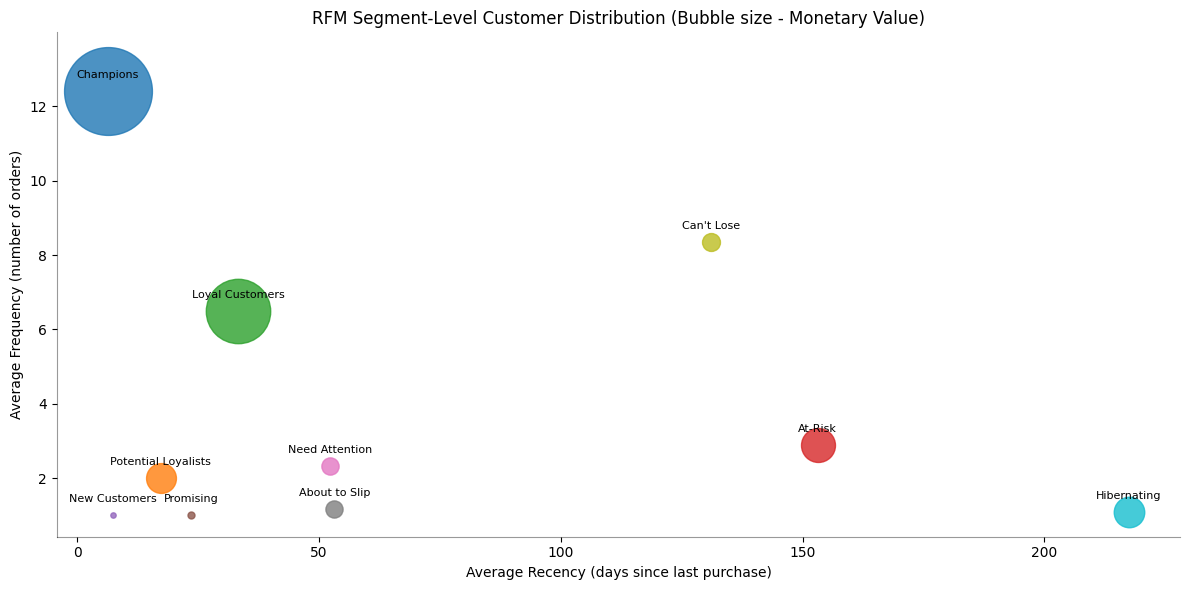

In [25]:
plt.figure(figsize=(12, 6))

sizes = (
    segment_summary["total_revenue"]
    / segment_summary["total_revenue"].max()
    * 4000
)

for segment, row in segment_summary.iterrows():
    plt.scatter(
        row["avg_recency"],
        row["avg_frequency"],
        s=sizes[segment],
        color=segment_colors.get(segment, "#999999"),
        alpha=0.8
    )
    plt.text(
        row["avg_recency"],
        row["avg_frequency"] + 0.3,
        segment,
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.xlabel("Average Recency (days since last purchase)")
plt.ylabel("Average Frequency (number of orders)")
plt.title("RFM Segment-Level Customer Distribution (Bubble size - Monetary Value)")

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_alpha(0.4)
ax.spines["bottom"].set_alpha(0.4)
y_min, y_max = ax.get_ylim()
ax.set_ylim(y_min, y_max + 1)

plt.tight_layout()
plt.show()

##### ➤ Insights. **RFM Segmentation**

| Segment Group            | Insight                                                                 | Business Implication |
|--------------------------|-------------------------------------------------------------------------|----------------------|
| Low-engagement customers | Segments such as **Hibernating 24.71%**, **At-Risk 13.79%**, and **About to Slip 8.14%** account for a large share of total customers, but contribute relatively little to overall revenue **15.03%**. This indicates a sizable pool of inactive or disengaged customers with limited current value.                            | Deploy reactivation campaigns such as limited-time discounts or targeted messaging to prevent further churn. |
| High-value customers     | **Champions 14.59%** and **Loyal Customers 18.72%** represent a smaller percentage of customers, yet generate a disproportionately large share of total revenue **74.94%**.        | Focus on retention through loyalty programs, exclusive offers, or early access to new products, as losing even a small share of these customers could significantly impact revenue. |
| Growth segment           | **Potential Loyalists 11.09%** shows recent engagement with room for increased purchasing. Converting even a portion of these customers into Loyal Customers or Champions could materially increase total revenue.                                    | Use personalized follow-ups, reminders, or incentives to encourage repeat purchases and accelerate progression into higher-value segments. |
| Can't Lose pose a high risk customers  | Although small in number **Can't Lose 1.5%**, these customers historically generated high revenue but now show low recency.    | Apply win-back strategies selectively, prioritizing customers with higher historical monetary value.

---